In [1]:
import pandas as pd
import numpy as np
import requests
import time
import plotly.graph_objs as go
from scipy.optimize import minimize
from datetime import datetime, timedelta, date
from typing import Literal, Annotated, List

In [2]:
def ny_fed_fetcher(url: str, ffp: str) -> pd.DataFrame:
    try:    
        response = requests.get(url)
        if response.status_code == 200:
            with open(ffp, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192): 
                    if not chunk:
                        continue
                    f.write(chunk) 
    
            return pd.read_excel(ffp, parse_dates=["Effective Date"])
        else:
            raise Exception(f"Bad Status: {response.status}")
    except Exception as e:
        print(e)
        return pd.DataFrame()


def get_sofr_spot() -> pd.DataFrame:
    url = "https://markets.newyorkfed.org/read?productCode=50&eventCodes=520&startPosition=0&sort=postDt:-1&format=xlsx"
    full_file_path = r"C:\Users\chris\trade\curr_pos\rates\sofr_spot.xlsx"
    return ny_fed_fetcher(url, full_file_path)
    
    
def get_sofr_averages_index() -> pd.DataFrame:
    url = "https://markets.newyorkfed.org/read?productCode=50&eventCodes=525&&startPosition=0&sort=postDt:-1&format=xlsx" 
    full_file_path = r"C:\Users\chris\trade\curr_pos\rates\sofr_averages.xlsx"
    return ny_fed_fetcher(url, full_file_path)

    
def get_effr_spot() -> pd.DataFrame:
    url = "https://markets.newyorkfed.org/read?productCode=50&eventCodes=500&startPosition=0&sort=postDt:-1&format=xlsx"
    full_file_path = r"C:\Users\chris\trade\curr_pos\rates\effr_spot.xlsx"
    return ny_fed_fetcher(url, full_file_path)

In [3]:
def plot_ref_rates(
    df_sofr: pd.DataFrame = None,
    df_effr: pd.DataFrame = None,
    plot_spread=False,
    date_subset_range: Annotated[List[date], 2] | None = None,
):
    df_sofr_copy = df_sofr.copy() if df_sofr is not None else None
    df_effr_copy = df_effr.copy() if df_effr is not None else None

    if date_subset_range:
        df_sofr_copy = (
            df_sofr_copy[
                (df_sofr_copy["Effective Date"] >= date_subset_range[0])
                & (df_sofr_copy["Effective Date"] <= date_subset_range[1])
            ]
            if df_sofr_copy is not None
            else None
        )
        df_effr_copy = (
            df_effr_copy[
                (df_effr_copy["Effective Date"] >= date_subset_range[0])
                & (df_effr_copy["Effective Date"] <= date_subset_range[1])
            ]
            if df_effr_copy is not None
            else None
        )

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=df_sofr_copy["Effective Date"],
            y=df_sofr_copy["Rate (%)_x"],
            mode="lines",
            name="SOFR Spot",
        )
    ) if df_sofr_copy is not None else None
    fig.add_trace(
        go.Scatter(
            x=df_effr_copy["Effective Date"],
            y=df_effr_copy["Rate (%)"],
            mode="lines",
            name="EFFR Spot",
        )
    ) if df_effr_copy is not None else None

    if plot_spread:
        merged_df = pd.merge(df_effr_copy, df_sofr_copy, on="Effective Date", how="inner")
        merged_df["Spread"] = merged_df["Rate (%)"] - merged_df["Rate (%)_x"]
        fig.add_trace(
            go.Scatter(
                x=merged_df["Effective Date"],
                y=merged_df["Spread"],
                mode="lines",
                name="Spread",
                yaxis="y2",
            )
        )

    fig.update_layout(
        title=f"SOFR & EEFR Daily Rates",
        xaxis_title="Date",
        yaxis=dict(
            title="Rate",
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue"),
        ),
        yaxis2=dict(
            title="Spread",
            titlefont=dict(color="green"),
            tickfont=dict(color="green"),
            overlaying="y",
            side="right",
        ),
        showlegend=True,
    )

    fig.show()

In [4]:
df_effr = get_effr_spot()
df_effr.head()

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Effective Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),Target Rate From (%),Target Rate To (%),Intra Day - Low (%),Intra Day - High (%),Standard Deviation (%),30-Day Average SOFR,90-Day Average SOFR,180-Day Average SOFR,SOFR Index,Revision Indicator (Y/N),Footnote ID
0,2023-12-05,EFFR,5.33,5.3,5.32,5.33,5.45,103.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-04,EFFR,5.33,5.3,5.32,5.33,5.45,103.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-01,EFFR,5.33,5.3,5.32,5.33,5.44,107.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-11-30,EFFR,5.33,5.3,5.32,5.34,5.50,91.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-29,EFFR,5.33,5.3,5.32,5.33,5.50,96.0,5.25,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_sofr_spot = get_sofr_spot()
df_sofr_avg_index = get_sofr_averages_index()
df_sofr = pd.merge(df_sofr_spot, df_sofr_avg_index, on="Effective Date")
df_sofr.head()

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Effective Date,Rate Type_x,Rate (%)_x,1st Percentile (%)_x,25th Percentile (%)_x,75th Percentile (%)_x,99th Percentile (%)_x,Volume ($Billions)_x,Target Rate From (%)_x,Target Rate To (%)_x,...,Target Rate To (%)_y,Intra Day - Low (%)_y,Intra Day - High (%)_y,Standard Deviation (%)_y,30-Day Average SOFR_y,90-Day Average SOFR_y,180-Day Average SOFR_y,SOFR Index_y,Revision Indicator (Y/N)_y,Footnote ID_y
0,2023-12-06,SOFR,5.32,5.28,5.31,5.41,5.45,1707,NaN,NaN,...,NaN,NaN,NaN,NaN,5.33877,5.35014,5.31178,1.110827,NaN,NaN
1,2023-12-05,SOFR,5.33,5.28,5.31,5.42,5.47,1792,NaN,NaN,...,NaN,NaN,NaN,NaN,5.33844,5.34980,5.31018,1.110662,NaN,NaN
2,2023-12-04,SOFR,5.37,5.28,5.31,5.44,5.48,1631,NaN,NaN,...,NaN,NaN,NaN,NaN,5.33674,5.34913,5.30835,1.110497,NaN,NaN
3,2023-12-01,SOFR,5.39,5.28,5.32,5.45,5.50,1650,NaN,NaN,...,NaN,NaN,NaN,NaN,5.33007,5.34643,5.30272,1.109998,NaN,NaN
4,2023-11-30,SOFR,5.33,5.28,5.31,5.44,5.51,1850,NaN,NaN,...,NaN,NaN,NaN,NaN,5.33074,5.34618,5.30124,1.109834,NaN,NaN


In [8]:
plot_ref_rates(df_sofr, df_effr, date_subset_range=[datetime(2023, 11, 1), datetime(2023, 12, 6)], plot_spread=True)
# plot_ref_rates(df_sofr, df_effr, plot_spread=True)
# plot_ref_rates(df_sofr, df_effr)

In [8]:
today = datetime.today()
diff = max(1, (today.weekday() + 6) % 7 - 3)
most_recent_business_day = today - timedelta(days=diff)

# Friday spot prices are updated on Monday, use Thursdays if running on weekend 
if today.weekday() in (5, 6):
    most_recent_business_day = most_recent_business_day - timedelta(days=1)
    
date_range = [
    most_recent_business_day,
    most_recent_business_day + timedelta(weeks=52 * 40),
]

C:\Users\chris\AppData\Local\Temp\ipykernel_53844\569069278.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



2023-05-12    0.0533
2023-05-15    0.0000
2023-05-16    0.0000
2023-05-17    0.0000
2023-05-18    0.0000
Freq: B, dtype: float64

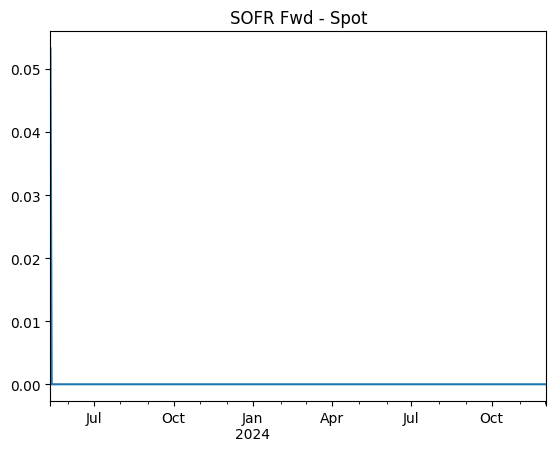

In [9]:
fwd_dates = pd.bdate_range(
    start=date_range[0].strftime("%d/%m/%Y"), end=date_range[1].strftime("%d/%m/%Y")
)
fwd_rates = np.array([0] * len(fwd_dates))
fwd_rates = pd.Series(fwd_rates, index=fwd_dates)
row = df_sofr.loc[
    df_sofr["Effective Date"] == most_recent_business_day.strftime("%Y-%m-%d")
]
fwd_rates.iloc[0] = row.iloc[0]["Rate (%)_x"] / 100

fwd_rates[fwd_rates.index <= (date_range[0] + timedelta(weeks=52))].plot(
    title="SOFR Fwd - Spot"
)

fwd_rates.head()

In [96]:
def flatten_json(y):
    out = {}

    def flatten(x, name=""):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + "_")
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + "_")
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


SOFRProducts = Literal["SR1", "SR3", "ZQ"]
product_codes = {"SR1": 8463, "SR3": 8462, "ZQ": 305}


def get_cme_sofr_futures(product: SOFRProducts, make_xlsx=False, parent_dir=None, set_contract_key=False) -> pd.DataFrame:
    now = round(time.time() * 1000)
    url = f"https://www.cmegroup.com/CmeWS/mvc/Quotes/Future/{product_codes[product]}/G?isProtected&_t={now}"
    try:
        res = requests.get(url)
        if res.status_code != 200:
            raise Exception("Bad Status Code")
        json = res.json()
        as_of = json["tradeDate"]
        quotes = [flatten_json(o) for o in (json["quotes"])]
        df = pd.DataFrame(quotes)
        file_name = f"{parent_dir}/{product}_quotes.xlsx" if parent_dir else f"{product}_quotes.xlsx" 
        df.to_excel(file_name, index=False, sheet_name=as_of) if make_xlsx else None
        df = df.set_index("expirationMonth") if set_contract_key else df
        return df 
    except Exception as e:
        print(e)
        return pd.DataFrame()
    
    
def get_cme_volume_date(product: SOFRProducts, dt: datetime):
    now = round(time.time() * 1000)
    dt_str = dt.strftime("%Y%m%d")
    url = f"https://www.cmegroup.com/CmeWS/mvc/Volume/Details/F/{product_codes[product]}/{dt_str}/P?tradeDate={dt_str}&isProtected&_t={now}"
    print(url)

In [109]:
get_cme_volume_date("SR3", datetime(2023, 10, 18))

https://www.cmegroup.com/CmeWS/mvc/Volume/Details/F/8462/20231018/P?tradeDate=20231018&isProtected&_t=1701646056111


In [86]:
sr1_df = get_cme_sofr_futures("SR1", True, r'C:\Users\chris\trade\curr_pos\futures', set_contract_key=True)
sr1_df

,last,change,priorSettle,open,close,high,low,highLimit,lowLimit,volume,...,priceChart_code,priceChart_monthYear,priceChart_venue,priceChart_title,priceChart_year,group,netChangeStatus,highLowLimits,isFrontMonth,lastUpdated
expirationMonth,,,,,,,,,,,,,,,,,,,,,
DEC 2023,94.67,UNCH,94.67,94.67,-,94.6725,94.6675,-,0.0025,"37,502",...,SR1,Z3,0,Chart+-+Dec+2023+One-Month+SOFR,2023,Interest Rate,statusNull,No Limit / 0.0025,False,2023-12-02T22:00:06.086
JAN 2024,94.665,+0.005,94.66,94.66,-,94.67,94.655,-,0.0025,"72,158",...,SR1,F4,0,Chart+-+Jan+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
FEB 2024,94.70,+0.04,94.66,94.67,-,94.705,94.67,-,0.0025,"101,613",...,SR1,G4,0,Chart+-+Feb+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
MAR 2024,94.745,+0.05,94.695,94.71,-,94.755,94.70,-,0.0025,"28,068",...,SR1,H4,0,Chart+-+Mar+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
APR 2024,94.835,+0.07,94.765,94.775,-,94.85,94.77,-,0.0025,"28,448",...,SR1,J4,0,Chart+-+Apr+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
MAY 2024,95.02,+0.115,94.905,94.93,-,95.035,94.915,-,0.0025,"23,239",...,SR1,K4,0,Chart+-+May+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,True,2023-12-02T22:00:06.086
JUN 2024,95.14,+0.13,95.01,95.04,-,95.155,95.015,-,0.0025,"7,438",...,SR1,M4,0,Chart+-+Jun+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
JUL 2024,95.22,+0.145,95.075,95.11,-,95.245,95.08,-,0.0025,"6,055",...,SR1,N4,0,Chart+-+Jul+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086
AUG 2024,95.42,+0.18,95.24,95.275,-,95.435,95.245,-,0.0025,"2,666",...,SR1,Q4,0,Chart+-+Aug+2024+One-Month+SOFR,2024,Interest Rate,statusOK,No Limit / 0.0025,False,2023-12-02T22:00:06.086


In [ ]:
def plot_impiled_yield(df_sofr: pd.DataFrame):
    df_sofr_copy = df_sofr.copy()
    
    fig = go.Figure()
    for date in date_range:
        formatted_date = date.strftime('%Y-%m-%d')
        tooltip_formatted_date = date.strftime('%m/%d/%Y') 
        yields = df.loc[df["Date"] == formatted_date]
        yields = yields.values.tolist()[0]
        del yields[0]

        if reverse_mats:
            yields.reverse()
            maturities.reverse()

        fig.add_trace(
            go.Scatter(x=adjusted_months, y=yields, mode="lines+markers", name=f"{tooltip_formatted_date}")
        )

    formatted_title = f"{date_range[0].strftime('%Y-%m-%d')} vs {date_range[1].strftime('%Y-%m-%d')} Yield Curve"
    fig.update_layout(
        title=formatted_title if not real_yields else f"{formatted_title} (Real)",
        xaxis_title="Maturity (Months)",
        yaxis_title="Yield (%)",
        xaxis=dict(tickvals=adjusted_months, ticktext=maturities),
        showlegend=False,
    )

    fig.show()

In [87]:
def set_rates(fwd_rates, rate, start, end):
    fwd_rates[(fwd_rates.index >= start) & (fwd_rates.index <= end)] = rate
    return fwd_rates


def sr1_pricer(sofr_fwd, N_days, days_passed=0, sr1_rzd=0):
    return 100 - (sr1_rzd + (N_days - days_passed) * sofr_fwd) / N_days


def sr1_boot(quote, N_days, days_passed=0, sr1_rzd=0):
    return ((100 - quote) * N_days - sr1_rzd) / (N_days - days_passed)

<AxesSubplot: title={'center': 'SOFR Fwd - Spot and SR1'}>

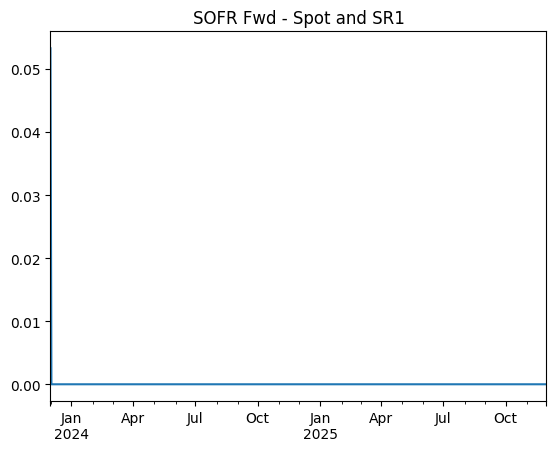

In [93]:
fwd_rates = set_rates(fwd_rates, sr1_boot(94.67, 2), '12/01/2024', '01/31/2024')
fwd_rates[fwd_rates.index <='12/1/2025'].plot(title='SOFR Fwd - Spot and SR1')